<a href="https://colab.research.google.com/github/lorenzo-stacchio/Fashion-in-The-Metaverse-Tutorial/blob/main/Artificial%20Intelligence/Fashion_in_the_Metaverse_CN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ver since Stable Diffusion took the world by storm, people have been looking for ways to have more control over the results of the generation process. ControlNet provides a minimal interface allowing users to customize the generation process up to a great extent. With [ControlNet](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet), users can easily condition the generation with different spatial contexts such as a depth map, a segmentation map, a scribble, keypoints, and so on!



Or even  use it as your interior designer.

<table>
<tr style="text-align: center;">
    <th>Before</th>
    <th>After</th>
</tr>
<tr>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/house_depth.png" width=300/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/house_after.jpeg" width=300/></td>
</tr>
</table>

You can turn your sketch scribble into an artistic drawing.

<table>
<tr style="text-align: center;">
    <th>Before</th>
    <th>After</th>
</tr>
<tr>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/drawing_before.png" width=300/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/drawing_after.jpeg" width=300/></td>
</tr>
</table>


With ControlNet, the sky is the limit 🌠

In this notebook, we first introduce the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) and then show how it can be applied for various control conditionings. Let’s get controlling!

## ControlNet: TL;DR

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) by Lvmin Zhang and Maneesh Agrawala.
It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

Training ControlNet is comprised of the following steps:

1. Cloning the pre-trained parameters of a Diffusion model, such as Stable Diffusion's latent UNet, (referred to as “trainable copy”) while also maintaining the pre-trained parameters separately (”locked copy”). It is done so that the locked parameter copy can preserve the vast knowledge learned from a large dataset, whereas the trainable copy is employed to learn task-specific aspects.
2. The trainable and locked copies of the parameters are connected via “zero convolution” layers (see [here](https://github.com/lllyasviel/ControlNet#controlnet) for more information) which are optimized as a part of the ControlNet framework. This is a training trick to preserve the semantics already learned by frozen model as the new conditions are trained.

Pictorially, training a ControlNet looks like so:

<p align="center">
    <img src="https://github.com/lllyasviel/ControlNet/raw/main/github_page/sd.png" alt="controlnet-structure"><br>
    <em>The diagram is taken from <a href=https://github.com/lllyasviel/ControlNet/blob/main/github_page/sd.png>here</a>.</em>
</p>

A sample from the training set for ControlNet-like training looks like this (additional conditioning is via edge maps):

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
     <td style="vertical-align: middle">"bird"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_bird.png" width=200/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/canny_map.png" width=200/></td>
</tr>
</table>

Similarly, if we were to condition ControlNet with semantic segmentation maps, a training sample would be like so:

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
    <td style="vertical-align: middle">"big house"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_house.png" width=300/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/segmentation_map.png" width=300/></td>
</tr>
</table>

Every new type of conditioning requires training a new copy of ControlNet weights.
The paper proposed 8 different conditioning models that are all [supported](https://huggingface.co/lllyasviel?search=controlnet) in Diffusers!

For inference, both the pre-trained diffusion models weights as well as the trained ControlNet weights are needed. For example, using [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
with a ControlNet checkpoint require roughly 700 million more parameters compared to just using the original Stable Diffusion model, which makes ControlNet a bit more memory-expensive for inference.

Because the pre-trained diffusion models are looked during training, one only needs to switch out the ControlNet parameters when using a different conditioning. This makes it fairly simple
to deploy multiple ControlNet weights in one application as we will see below.

# The `StableDiffusionControlNetPipeline`

Before we begin, we want to give a huge shout-out to the community contributor [Takuma Mori](https://github.com/takuma104) for having led the integration of ControlNet into Diffusers ❤️ .

To experiment with ControlNet, Diffusers exposes the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) similar to
the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview). Central to the [`StableDiffusionControlNetPipeline`] is the `controlnet` argument which lets us provide a particular trained [`ControlNetModel`](https://huggingface.co/docs/diffusers/main/en/api/models#diffusers.ControlNetModel) instance while keeping the pre-trained diffusion model weights the same.

We will explore different use cases with the `StableDiffusionControlNetPipeline` in this blog post. The first ControlNet model we are going to walk through is the [Canny model](https://huggingface.co/runwayml/stable-diffusion-v1-5) - this is one of the most popular models that generated some of the amazing images you are libely seeing on the internet.

We welcome you to run the code snippets shown in the sections below with [this Colab Notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/controlnet.ipynb).

Before we begin, let's make sure we have all the necessary libraries installed:

In [1]:
! pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


To process different conditionings depending on the chosen ControlNet, we also need to install some
additional dependencies:
- [OpenCV](https://opencv.org/)
- [controlnet-aux](https://github.com/patrickvonplaten/controlnet_aux#controlnet-auxiliary-models) - a simple collection of pre-processing models for ControlNet

In [2]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

We will use the famous painting ["Girl With A Pearl"](https://en.wikipedia.org/wiki/Girl_with_a_Pearl_Earring) for this example. So, let's download the image and take a look:

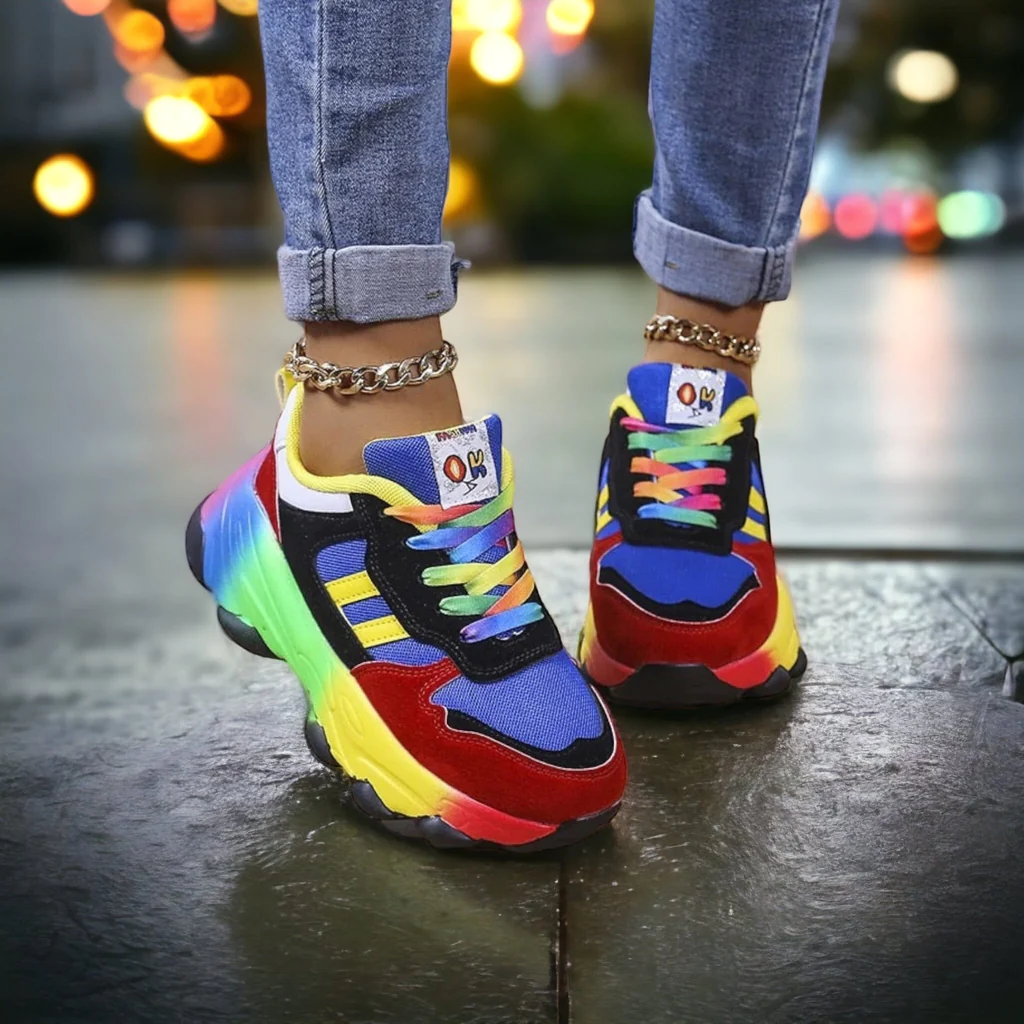

In [2]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    "https://github.com/lorenzo-stacchio/Fashion-in-The-Metaverse-Tutorial/blob/main/Artificial%20Intelligence/test_images/Mixblu1_1024x1024.png?raw=true"
)
image

Next, we will put the image through the canny pre-processor:

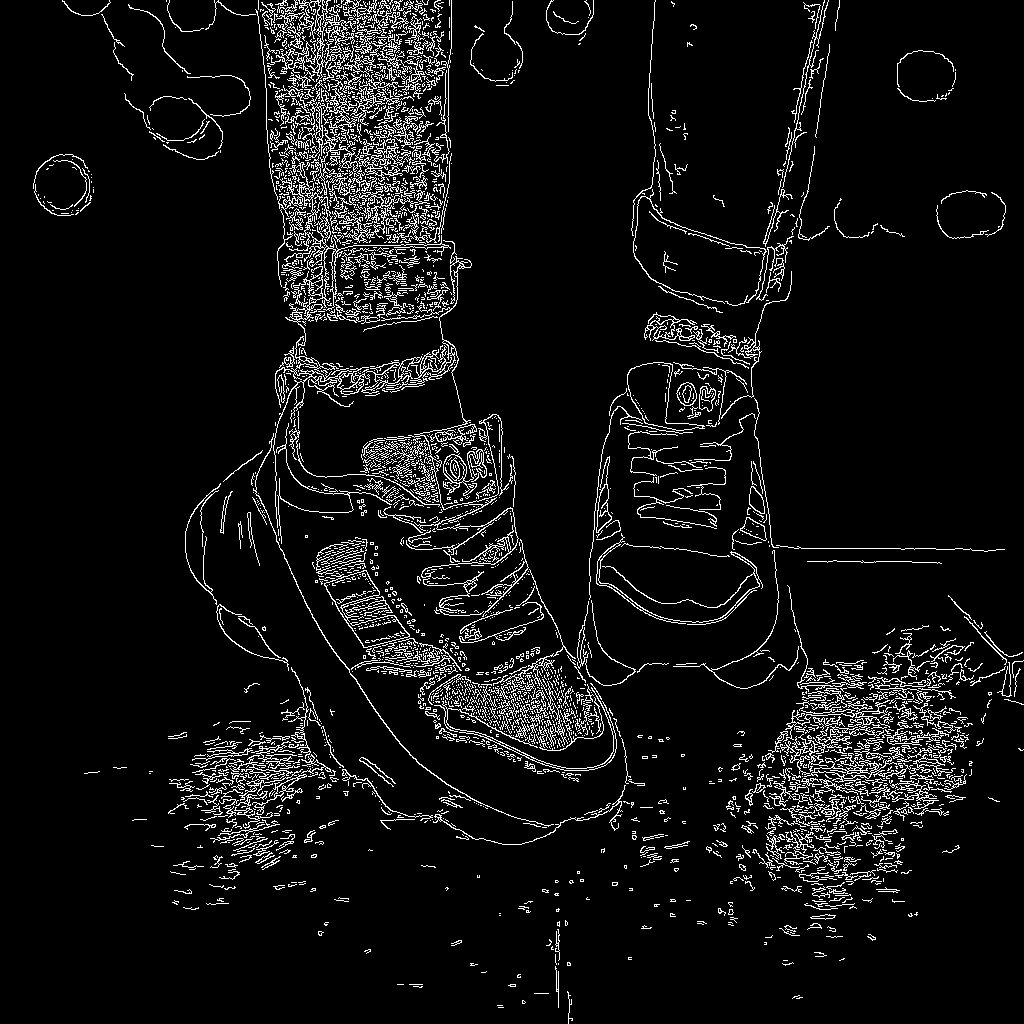

In [3]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

As we can see, it is essentially edge detection.

Now, we load [runwaylml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) as well as the [ControlNet model for canny edges](https://huggingface.co/lllyasviel/sd-controlnet-canny). The models are loaded in half-precision (`torch.dtype`) to allow for fast and memory-efficient inference.

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Instead of using Stable Diffusion's default [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm), we use one of the currently fastest
diffusion model schedulers, called [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc).
Choosing an improved scheduler can drastically reduce inference time - in our case we are able to reduce the number of inference steps from 50 to 20 while more or less
keeping the same image generation quality. More information regarding schedulers can be found [here](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

In [5]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Instead of loading our pipeline directly to GPU, we instead enable smart CPU offloading which
can be achieved with the [`enable_model_cpu_offload` function](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet#diffusers.StableDiffusionControlNetPipeline.enable_model_cpu_offload).

Remember that during inference diffusion models, such as Stable Diffusion require not just one but multiple model components that are run sequentially.
In the case of Stable Diffusion with ControlNet, we first use the CLIP text encoder, then the diffusion model unet and control net, then the VAE decoder and finally run a safety checker.
Most components are only run once during the diffusion process and are thus not required to occupy GPU memory all the time. By enabling smart model offloading, we make sure
that each component is only loaded into GPU when it's needed so that we can significantly save memory consumption without significantly slowing down infenence.

**Note**: When running `enable_model_cpu_offload`, do not manually move the pipeline to GPU with `.to("cuda")` - once CPU offloading is enabled, the pipeline automatically takes care of GPU memory management.

In [6]:
pipe.enable_model_cpu_offload()

Finally, we want to take full advantage of the amazing [FlashAttention/xformers](https://github.com/facebookresearch/xformers) attention layer acceleration, so let's enable this! If this command does not work for you, you might not have `xformers` correctly installed.
In this case, you can just skip the following line of code.

In [8]:
# pipe.enable_xformers_memory_efficient_attention()

Now we are ready to run the ControlNet pipeline!

We still provide a prompt to guide the image generation process, just like what we would normally do with a Stable Diffusion image-to-image pipeline. However, ControlNet will allow a lot more control over the generated image because we will be able to control the exact composition in generated image with the canny edge image we just created.

It will be fun to see some images where contemporary celebrities posing for this exact same painting from the 17th century. And it's really easy to do that with ControlNet, all we have to do is to include the names of these celebrities in the prompt!

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Green Fashion Shoes"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)

We can effortlessly combine ControlNet combines with fine-tuning too! For example, we can fine-tune a model with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth), and use it to render ourselves into different scenes.

In this post, we are going to use our beloved Mr Potato Head as an example to show how to use ControlNet with DreamBooth.

We can use the same ContrlNet, however instead of using the Stable Diffusion 1.5, we are going to load the [Mr Potato Head model](https://huggingface.co/sd-dreambooth-library/mr-potato-head) into our pipeline - Mr Potato Head is a Stable Diffusion model fine-tuned with Mr Potato Head concept using Dreambooth 🥔

Let's run the above commands again, keeping the same `controlnet` though!

## Controlnet: Pose conditioning

Another exclusive application of ControlNet is that we can take a pose from one image and reuse it to generate a different image with the exact same pose. So in this next example, we are going to teach superheroes how to do yoga using [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose)!

First, we will need to get some images of people doing yoga:

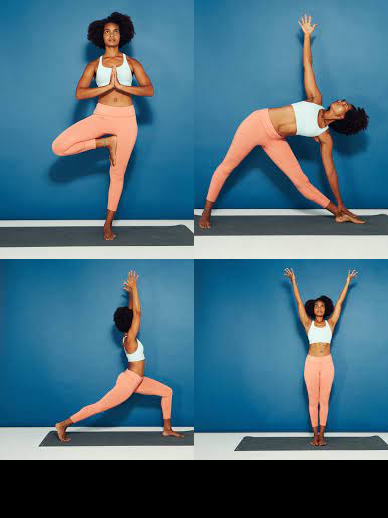

In [14]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url)
    for url in urls
]

image_grid(imgs, 2, 2)

Now let's extract yoga poses using the OpenPose pre-processors that are handily available via `controlnet_aux`.

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


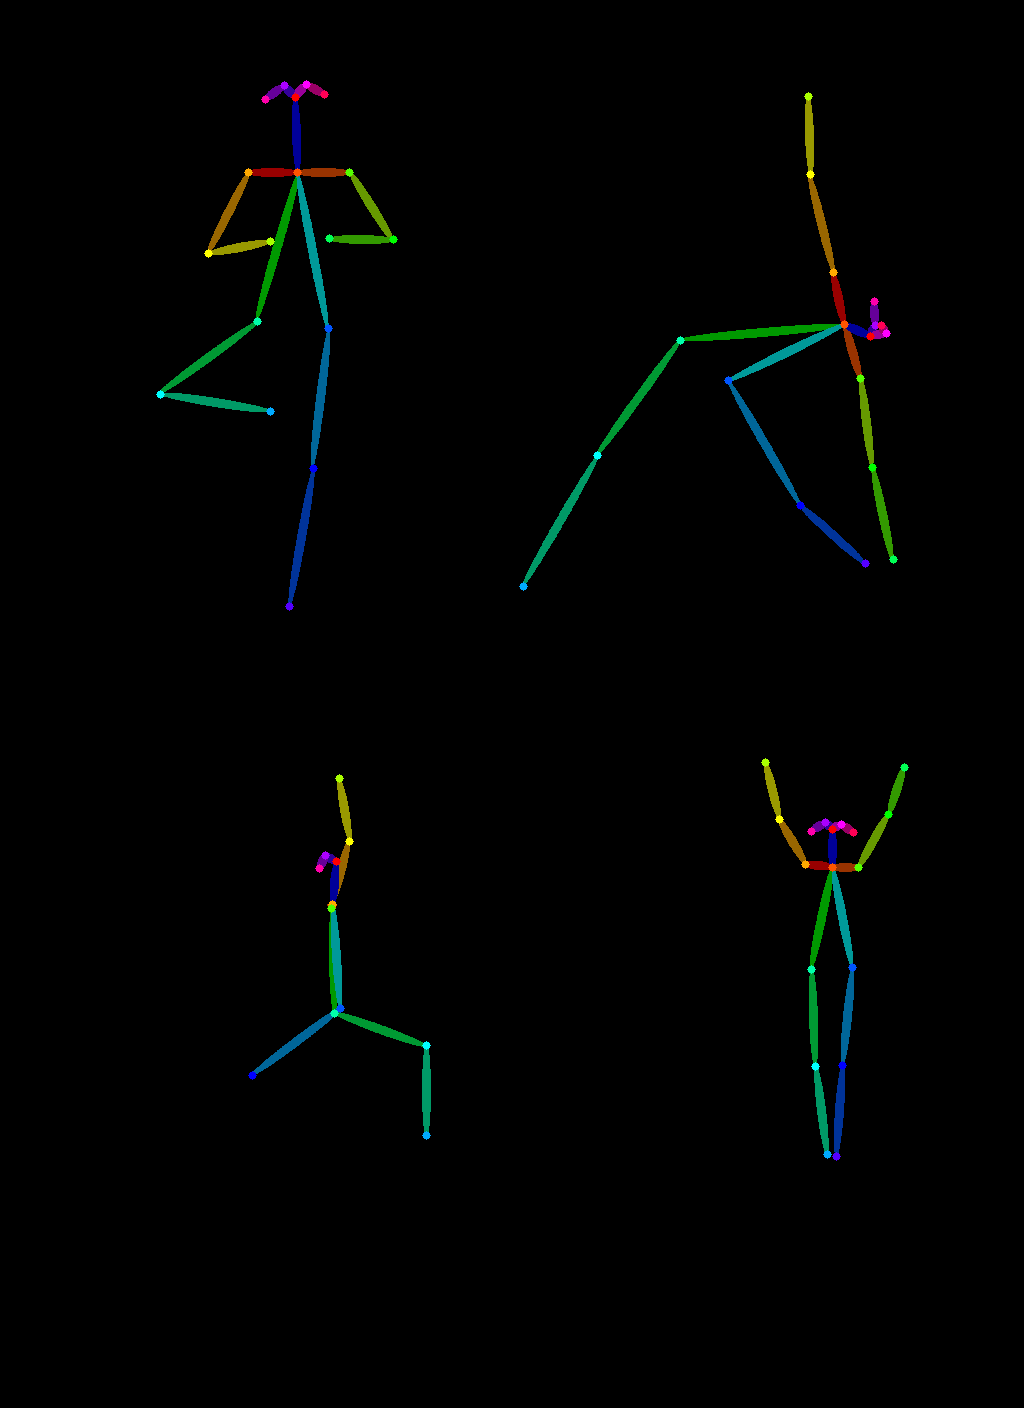

In [15]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

To use these yoga poses to generate new images, let's create a [Open Pose ControlNet](https://huggingface.co/lllyasviel/sd-controlnet-openpose). We will generate some super-hero images but in the yoga poses shown above. Let's go 🚀

In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Now it's yoga time!

In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "A Fashion model is wearing a pink shirt and black pants in yoga pose."
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

Throughout the examples, we explored multiple facets of the [`StableDiffusionControlNetPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet) to show how easy and intuitive it is play around with ControlNet via Diffusers. However, we didn't cover all types of conditionings supported by ControlNet. To know more about those, we encourage you to check out the respective model documentation pages:

* [lllyasviel/sd-controlnet-depth](https://huggingface.co/lllyasviel/sd-controlnet-depth)
* [lllyasviel/sd-controlnet-hed](https://huggingface.co/lllyasviel/sd-controlnet-hed)
* [lllyasviel/sd-controlnet-normal](https://huggingface.co/lllyasviel/sd-controlnet-normal)
* [lllyasviel/sd-controlnet-scribble](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
* [lllyasviel/sd-controlnet-seg](https://huggingface.co/lllyasviel/sd-controlnet-scribble)
* [lllyasviel/sd-controlnet-openpose](https://huggingface.co/lllyasviel/sd-controlnet-openpose)
* [lllyasviel/sd-controlnet-mlsd](https://huggingface.co/lllyasviel/sd-controlnet-mlsd)
* [lllyasviel/sd-controlnet-mlsd](https://huggingface.co/lllyasviel/sd-controlnet-canny)

We welcome you to combine these different elements and share your results with [@diffuserslib](https://twitter.com/diffuserslib). Be sure to check out [the Colab Notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/controlnet.ipynb) to take some of the above examples for a spin!

We also showed some techniques to make the generation process faster and memory-friendly by using a fast scheduler, smart model offloading and `xformers`. With these techniques combined the generation process should take only ~3 seconds on a V100 GPU and consumes just ~4 GBs of VRAM for a single image ⚡️